In [ ]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.arima.model import ARIMA
from dslabs_functions import series_train_test_split, HEIGHT

filename: str = "/content/traffic_smoothed_size_15.csv"
file_tag: str = "traffic"
target: str = "Total"
timecol: str = "t"
measure: str = "R2"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".")
series: Series = data[target]
train, test = series_train_test_split(data, trn_pct=0.90)

In [ ]:
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def arima_study(train: Series, test: Series, measure: str = "R2"):
    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                arima = ARIMA(train, order=(p, d, q))
                model = arima.fit()
                prd_tst = model.forecast(steps=len(test), signal_only=False)
                eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                # print(f"ARIMA ({p}, {d}, {q})", eval)
                if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                    best_performance: float = eval
                    best_params["params"] = (p, d, q)
                    best_model = model
                yvalues.append(eval)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params

ARIMA best results achieved with (p,d,q)=(5, 1, 7) ==> measure=0.07


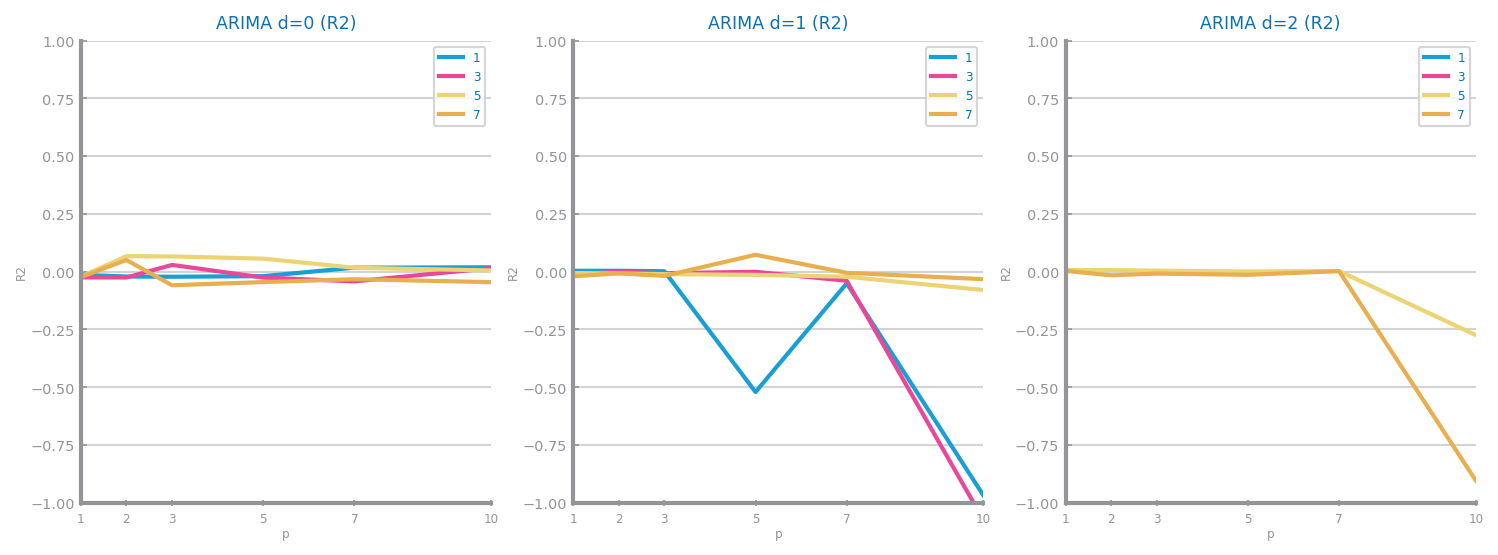

In [ ]:
from matplotlib.pyplot import savefig

best_model, best_params = arima_study(train, test, measure=measure)
savefig(f"{file_tag}_arima_{measure}_study.png")

ARIMA best results achieved with (p,d,q)=(5, 0, 7) ==> measure=0.08


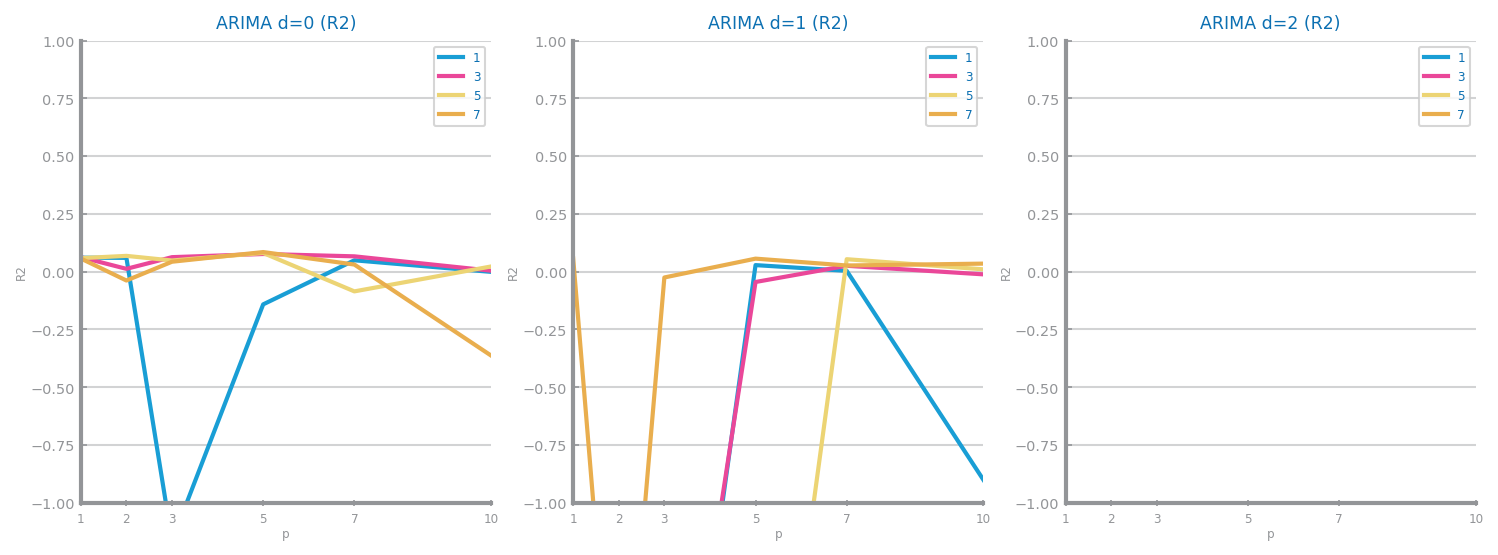

In [ ]:
from matplotlib.pyplot import savefig

best_model, best_params = arima_study(train, test, measure=measure)
savefig(f"{file_tag}_arima_{measure}_study_15.png")

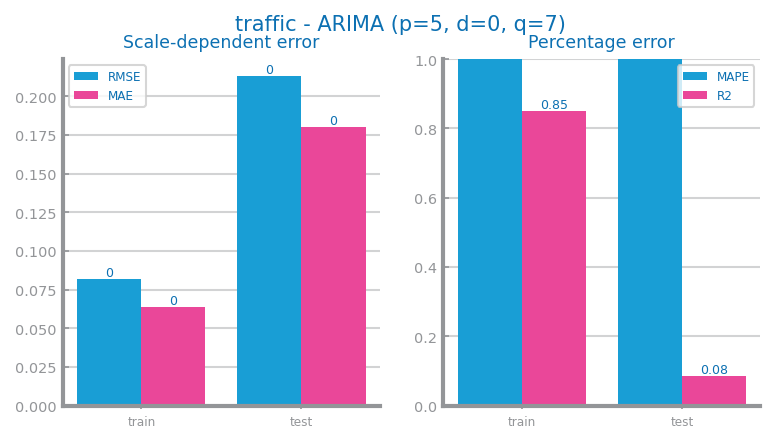

In [ ]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(
    train, test, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"{file_tag}_arima_{measure}_eval_15.png")

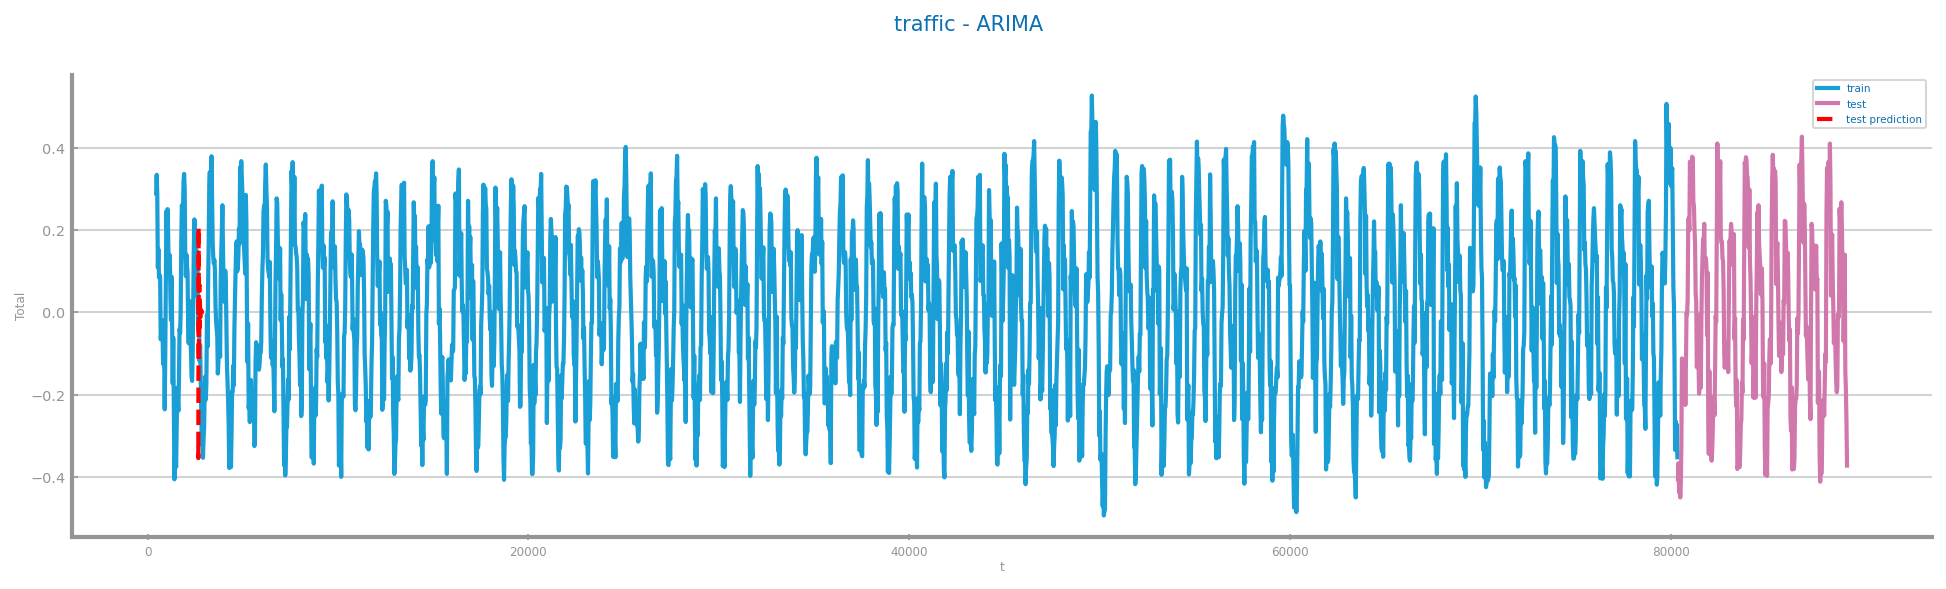

In [ ]:
from dslabs_functions import plot_forecasting_series

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - ARIMA ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{file_tag}_arima_{measure}_forecast_15.png")

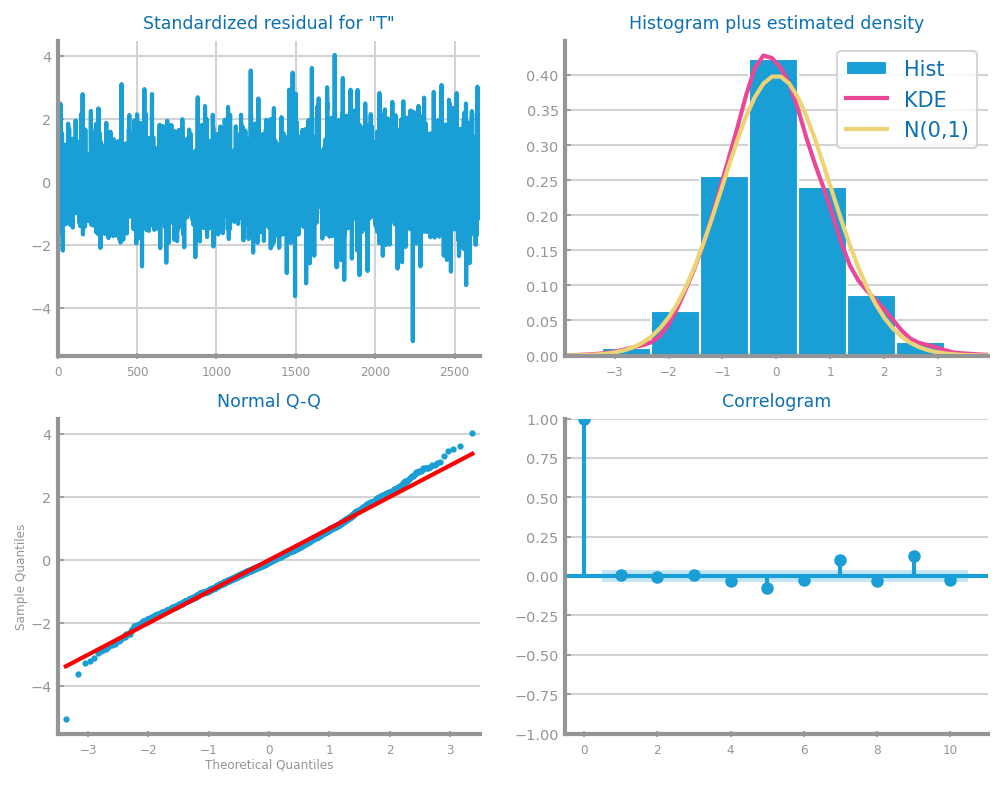

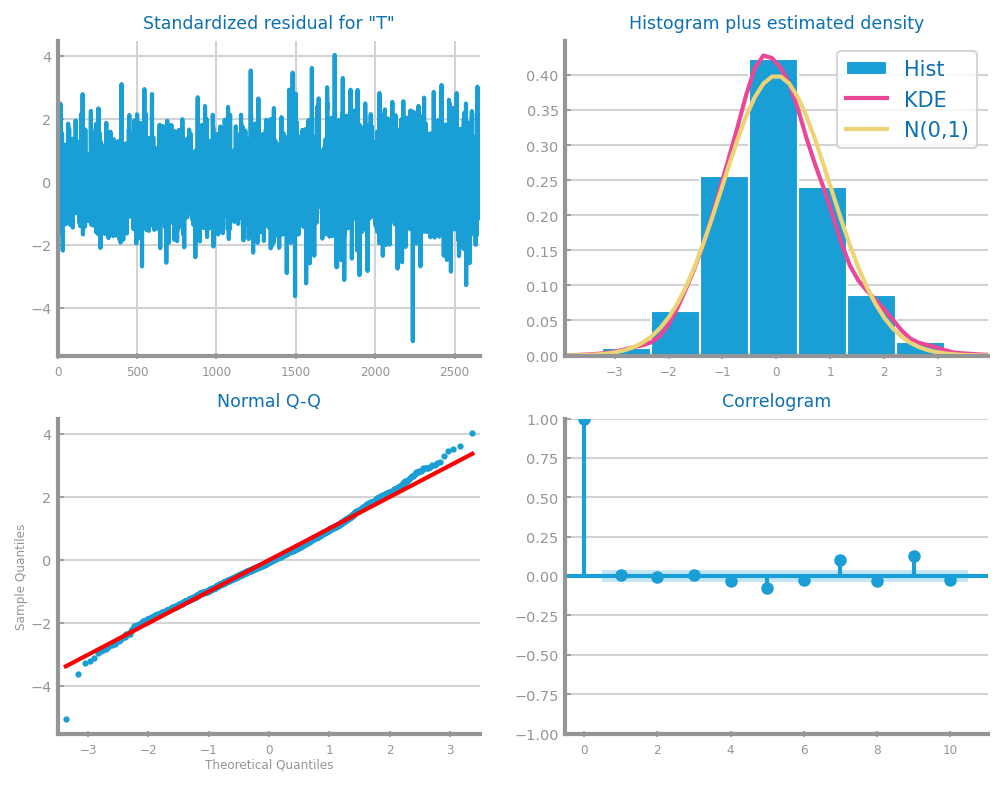

In [ ]:
best_model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))

In [ ]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                 2664
Model:                 ARIMA(5, 0, 7)   Log Likelihood                2885.339
Date:                Thu, 18 Dec 2025   AIC                          -5742.677
Time:                        16:13:12   BIC                          -5660.251
Sample:                             0   HQIC                         -5712.849
                               - 2664                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.607      0.544      -0.001       0.002
ar.L1         -0.0324      0.021     -1.550      0.121      -0.073       0.009
ar.L2          0.9721      0.021     46.969      0.0

LSTMs

In [ ]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


def prepare_dataset_for_lstm(series, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]
        future = series[i + 1 : i + seq_length + 1]
        setX.append(past)
        setY.append(future)
    return tensor(setX), tensor(setY)


class DS_LSTM(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]

In [ ]:
data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".")
series = data[[target]].values.astype("float32")

train_size = int(len(series) * 0.90)
train, test = series[:train_size], series[train_size:]

seq length=2 hidden_units=25 nr_episodes=0 0.08648049831390381
seq length=2 hidden_units=25 nr_episodes=300 0.7920506596565247
seq length=2 hidden_units=25 nr_episodes=600 0.7930471301078796
seq length=2 hidden_units=25 nr_episodes=900 0.7952365279197693
seq length=2 hidden_units=25 nr_episodes=1200 0.7970495223999023
seq length=2 hidden_units=25 nr_episodes=1500 0.7978714108467102
seq length=2 hidden_units=25 nr_episodes=1800 0.7982116937637329
seq length=2 hidden_units=25 nr_episodes=2100 0.7977703213691711
seq length=2 hidden_units=25 nr_episodes=2400 0.7974687218666077
seq length=2 hidden_units=25 nr_episodes=2700 0.7973204851150513
seq length=2 hidden_units=25 nr_episodes=3000 0.7981201410293579
seq length=2 hidden_units=50 nr_episodes=0 0.012244582176208496
seq length=2 hidden_units=50 nr_episodes=300 0.792098879814148
seq length=2 hidden_units=50 nr_episodes=600 0.7943092584609985
seq length=2 hidden_units=50 nr_episodes=900 0.7969160676002502
seq length=2 hidden_units=50 nr_epi

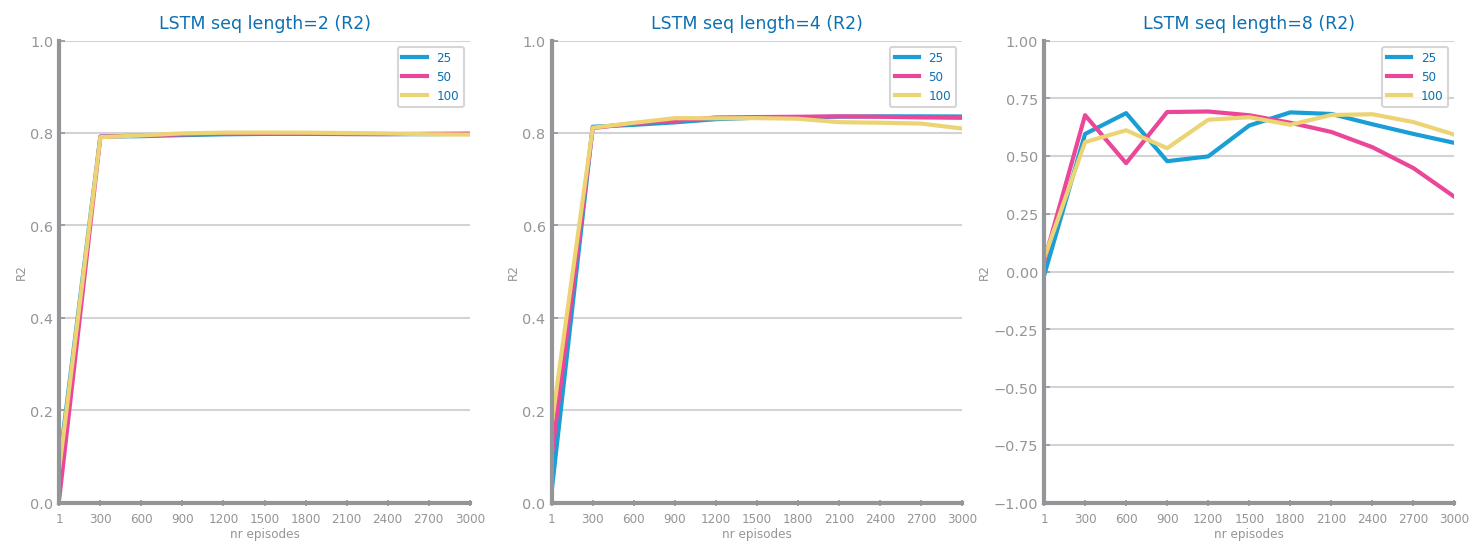

In [ ]:
from dslabs_functions import HEIGHT, plot_multiline_chart
from copy import deepcopy

from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def lstm_study(train, test, nr_episodes: int = 1000, measure: str = "R2"):
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(train, hidden_size=hidden)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = FORECAST_MEASURES[measure](test[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params["params"][0]} hidden_units={best_params["params"][1]} and nr_episodes={best_params["params"][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


best_model, best_params = lstm_study(train, test, nr_episodes=3000, measure=measure)

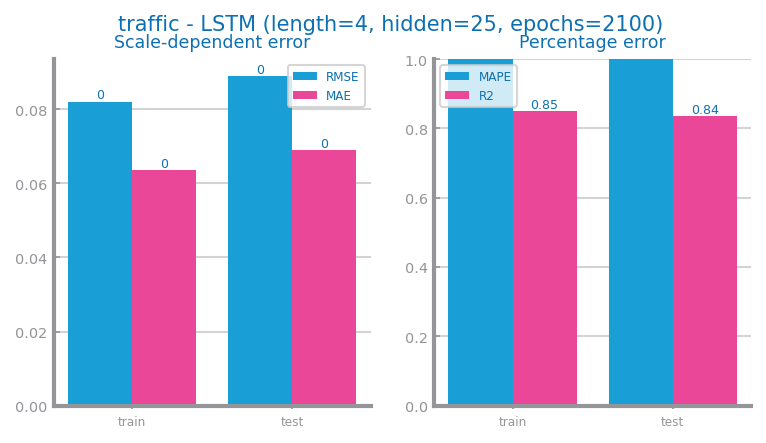

In [ ]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
best_length = params[0]
trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_forecasting_eval(
    train[best_length:],
    test[best_length:],
    prd_trn,
    prd_tst,
    title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})",
)
savefig(f"{file_tag}_lstms_{measure}_eval_15.png")

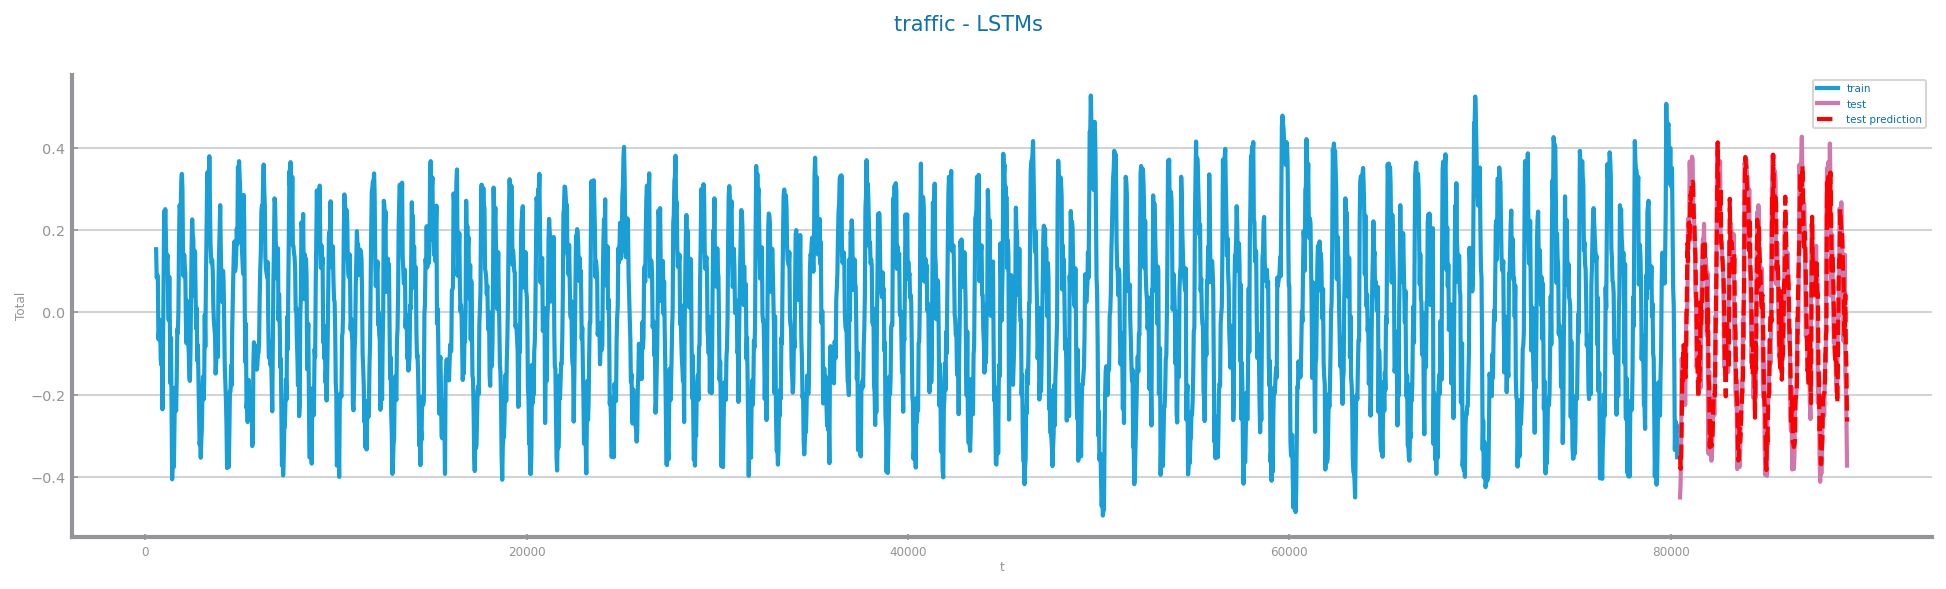

In [ ]:
from dslabs_functions import plot_forecasting_series

series = data[[target]]
train, test = series[:train_size], series[train_size:]
pred_series: Series = Series(prd_tst.numpy().ravel(), index=test.index[best_length:])

plot_forecasting_series(
    train[best_length:],
    test[best_length:],
    pred_series,
    title=f"{file_tag} - LSTMs ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{file_tag}_lstms_{measure}_forecast_15.png")

Exponential Smoothing

In [ ]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from dslabs_functions import series_train_test_split, HEIGHT

filename: str = "/content/traffic_smoothed_size_15.csv"
file_tag: str = "traffic"
target: str = "Total"
timecol: str = "t"
measure: str = "R2"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".")
series: Series = data[target]
train, test = series_train_test_split(data, trn_pct=0.90)

In [ ]:
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart


def exponential_smoothing_study(train: Series, test: Series, measure: str = "R2"):
    alpha_values = [i / 10 for i in range(1, 10)]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Exponential Smoothing", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for alpha in alpha_values:
        tool = SimpleExpSmoothing(train)
        model = tool.fit(smoothing_level=alpha, optimized=False)
        prd_tst = model.forecast(steps=len(test))

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (alpha,)
            best_model = model
        yvalues.append(eval)

    print(f"Exponential Smoothing best with alpha={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        alpha_values,
        yvalues,
        title=f"Exponential Smoothing ({measure})",
        xlabel="alpha",
        ylabel=measure,
        percentage=flag,
    )

    return best_model, best_params

Exponential Smoothing best with alpha=0 -> R2=-0.0055832365472401335


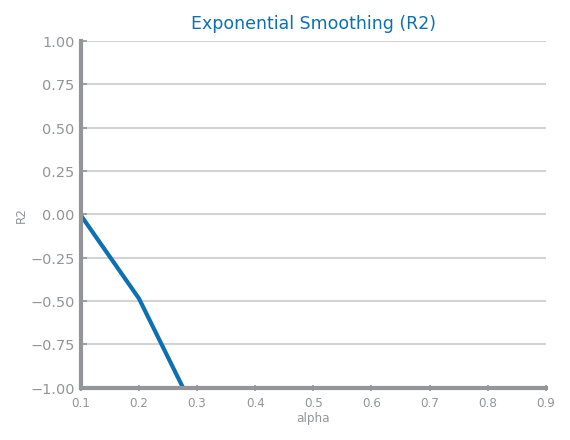

In [ ]:
from matplotlib.pyplot import savefig

best_model, best_params = exponential_smoothing_study(train, test, measure=measure)
savefig(f"{file_tag}_exponential_smoothing_{measure}_study_15.png")

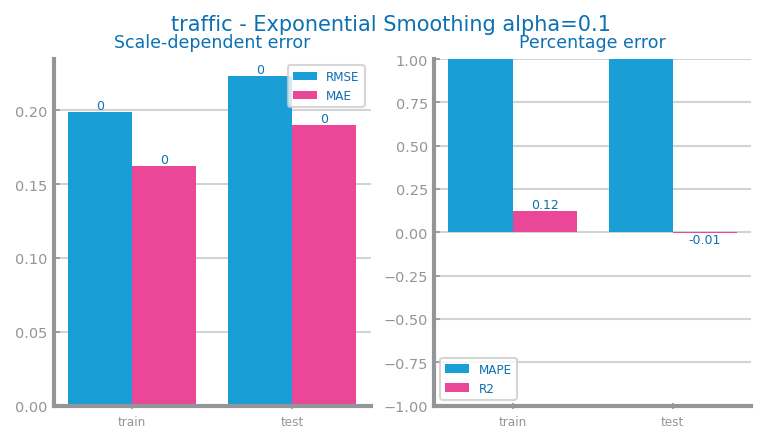

In [ ]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Exponential Smoothing alpha={params[0]}")
savefig(f"{file_tag}_exponential_smoothing_{measure}_eval_15.png")

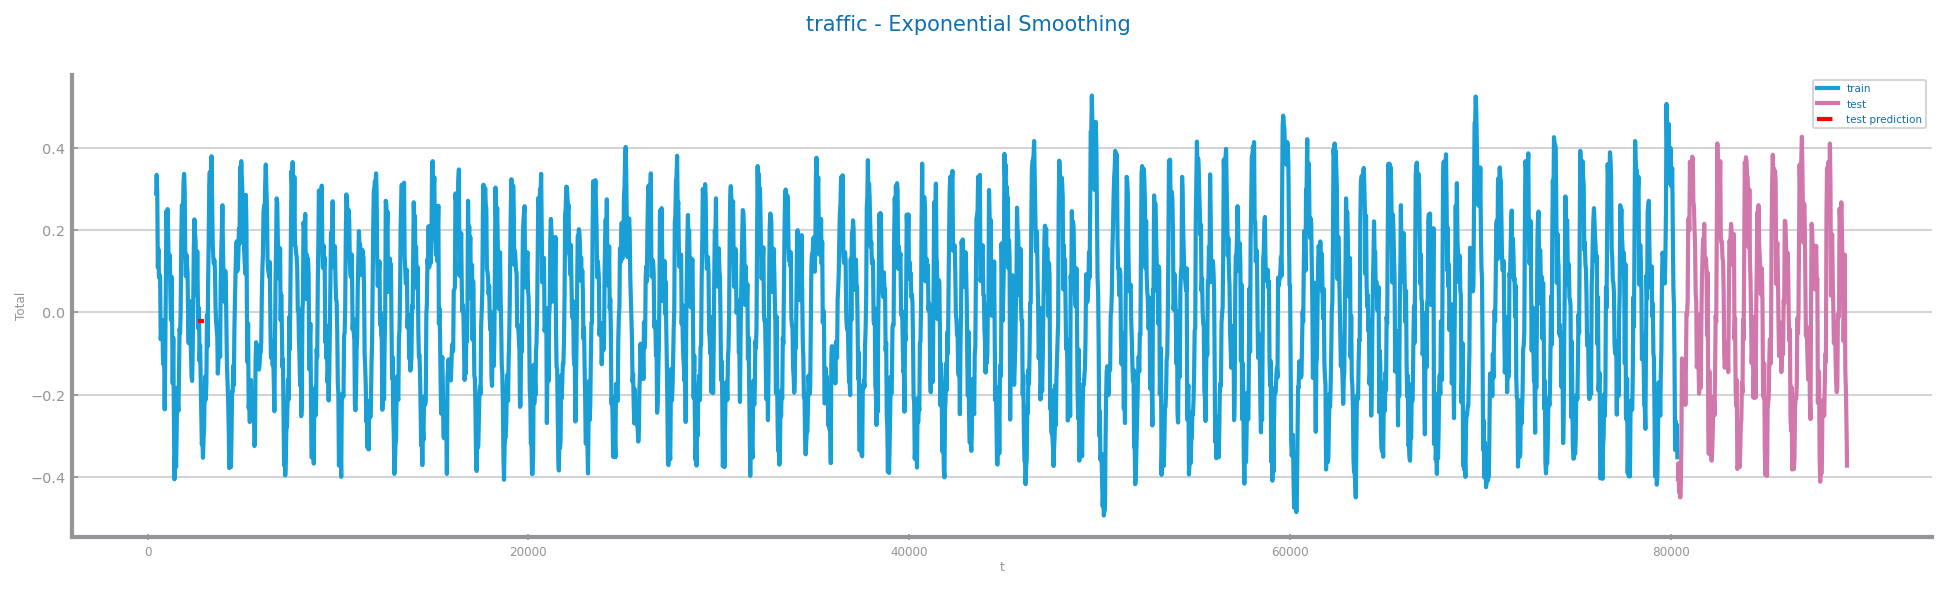

In [ ]:
from dslabs_functions import plot_forecasting_series

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Exponential Smoothing ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{file_tag}_exponential_smoothing_{measure}_forecast_15.png")

Multi-layer perceptrons

In [ ]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from dslabs_functions import series_train_test_split, HEIGHT

filename: str = "/content/traffic_smoothed_size_15.csv"
file_tag: str = "traffic"
target: str = "Total"
timecol: str = "t"
measure: str = "R2"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".")
series: Series = data[target]
train, test = series_train_test_split(data, trn_pct=0.90)

In [ ]:
import numpy as np

def create_windows(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib.pyplot import figure, show
import numpy as np

def mlp_forecasting_study(
    train_series,
    test_series,
    window_size=10,
    hidden_sizes=[(32,), (64,), (64,32)],
    learning_rates=[0.1, 0.01, 0.001],
    max_iters=[500, 1000, 2000]
):
    # 1. Criar janelas
    trnX, trnY = create_windows(train_series, window_size)
    tstX, tstY = create_windows(test_series, window_size)

    best_model = None
    best_params = None
    best_r2 = -999

    results = {}

    for h in hidden_sizes:
        for lr in learning_rates:
            for it in max_iters:

                model = MLPRegressor(
                    hidden_layer_sizes=h,
                    learning_rate_init=lr,
                    max_iter=it,
                    activation="relu",
                    solver="adam",
                    random_state=42
                )

                model.fit(trnX, trnY)
                pred = model.predict(tstX)

                mse = mean_squared_error(tstY, pred)
                mae = mean_absolute_error(tstY, pred)
                r2 = r2_score(tstY, pred)

                results[(h, lr, it)] = (mse, mae, r2)

                if r2 > best_r2:
                    best_r2 = r2
                    best_model = model
                    best_params = (h, lr, it)

    return best_model, best_params, results


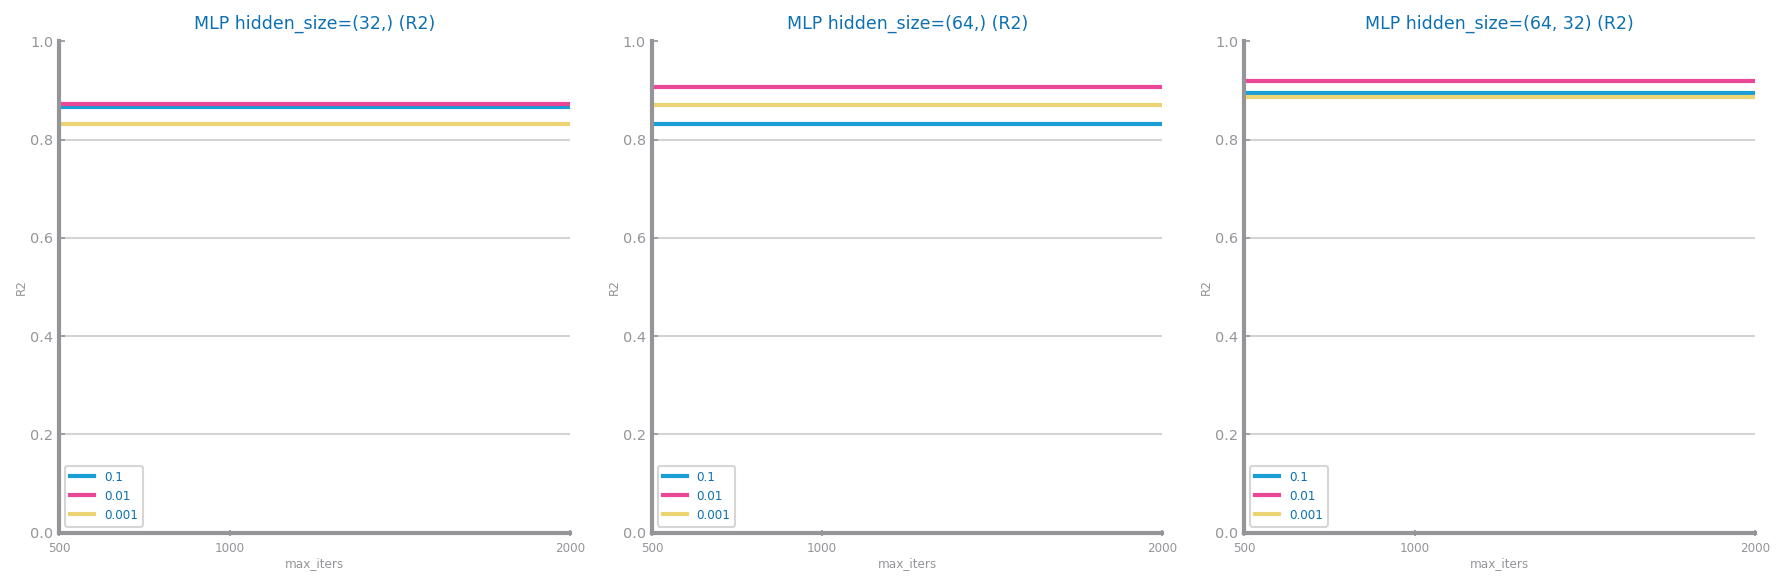

In [ ]:
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import HEIGHT, plot_multiline_chart

def mlp_study_plot(results, measure: str = "R2"):
    hidden_sizes=[(32,), (64,), (64,32)]
    learning_rates=[0.1, 0.01, 0.001]
    max_iters=[500, 1000, 2000]

    flag = measure == "R2" or measure == "MAPE"

    fig, axs = subplots(1, len(hidden_sizes), figsize=(len(hidden_sizes) * HEIGHT, HEIGHT))
    if len(hidden_sizes) == 1:
        axs = [axs]

    for i, h in enumerate(hidden_sizes):
        values = {}
        for lr in learning_rates:
            yvalues = []
            for it in max_iters:
                _, _, r2_score_val = results[(h, lr, it)]
                yvalues.append(r2_score_val)
            values[str(lr)] = yvalues # Convert lr to string for legend

        plot_multiline_chart(
            max_iters,
            values,
            ax=axs[i],
            title=f"MLP hidden_size={h} ({measure})",
            xlabel="max_iters",
            ylabel=measure,
            percentage=flag
        )
    fig.tight_layout()

mlp_study_plot(results, measure=measure)
savefig(f"{file_tag}_mlp_{measure}_study.png")

In [ ]:
best_model, best_params, results = mlp_forecasting_study(
    train_series=train.values,
    test_series=test.values,
    window_size=15
)

print("Best params:", best_params)

Best params: ((64, 32), 0.01, 500)


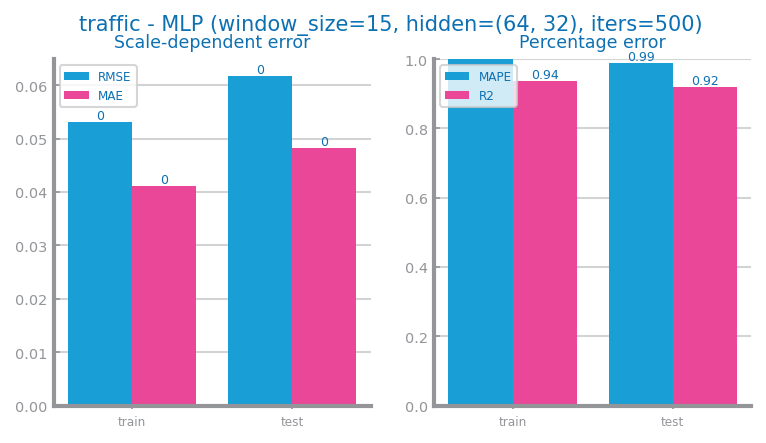

In [ ]:
mlp_window_size = 15


train_for_windows, _ = create_windows(train.values, mlp_window_size)
test_for_windows, _ = create_windows(test.values, mlp_window_size)

prd_trn_mlp = best_model.predict(train_for_windows)
prd_tst_mlp = best_model.predict(test_for_windows)

prd_trn_series_mlp = Series(prd_trn_mlp.ravel(), index=train.index[mlp_window_size:])
prd_tst_series_mlp = Series(prd_tst_mlp.ravel(), index=test.index[mlp_window_size:])

mlp_hidden_layers = best_params[0]
mlp_max_iters = best_params[2]

plot_forecasting_eval(
    train[mlp_window_size:],
    test[mlp_window_size:],
    prd_trn_series_mlp,
    prd_tst_series_mlp,
    title=f"{file_tag} - MLP (window_size={mlp_window_size}, hidden={mlp_hidden_layers}, iters={mlp_max_iters})",
)
savefig(f"{file_tag}_mlp_{measure}_eval.png")

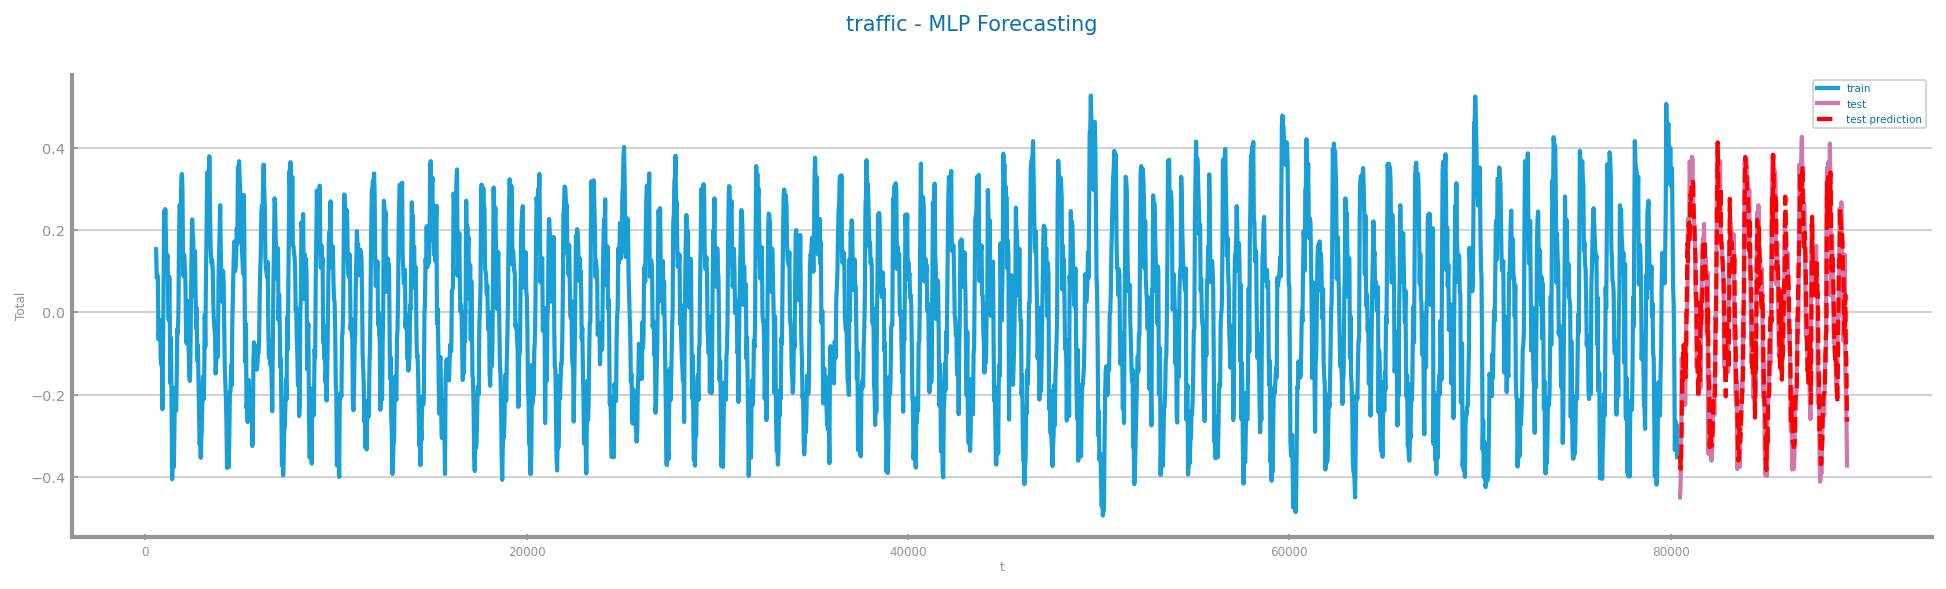

In [ ]:
plot_forecasting_series(
    train[best_length:],
    test[best_length:],
    pred_series,
    title=f"{file_tag} - MLP Forecasting",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{file_tag}_mlp_{measure}_forecast.png")
